In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 生成示例数据
# df = pd.read_csv("./test-out/s9_cluster.csv")
# 生成示例数据
df = pd.read_csv("./out/outputs1000.csv")
            

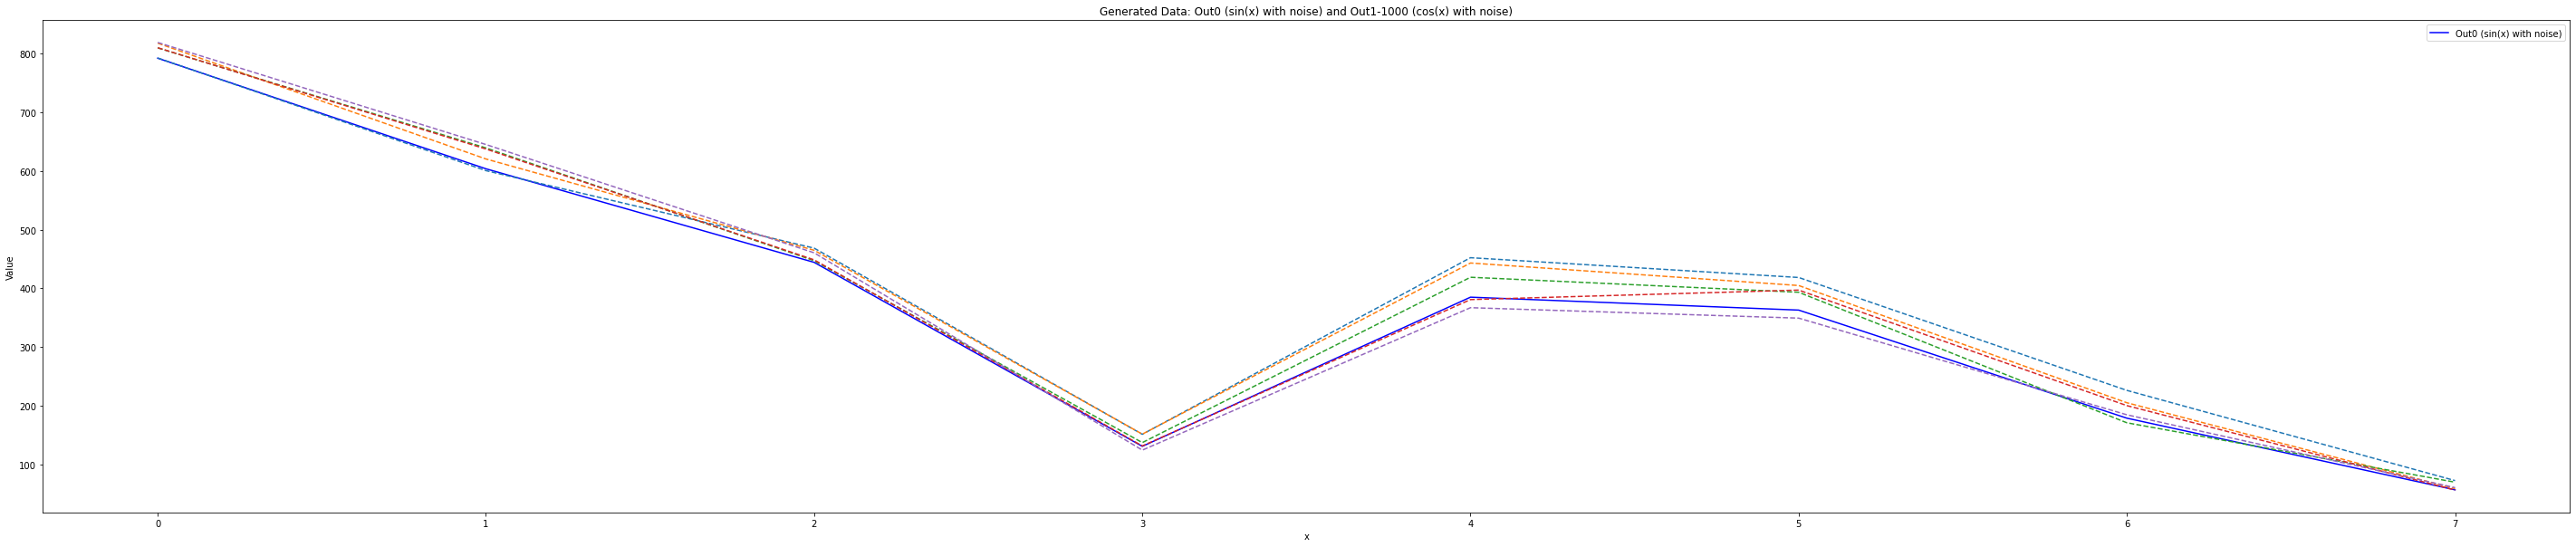

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings 

warnings.filterwarnings("ignore")


out0 =pd.read_csv("./out/outputs.csv")

x= df.index

data = df

data["Out0"]=out0["Out0"]

# 绘制图片
plt.figure(figsize=(50, 10))

# 绘制Out0数据
plt.plot(x, data["Out0"], label='Out0 (sin(x) with noise)', color='blue')

# 绘制Out1到Out5数据作为示例
for i in range(1, 6):
    plt.plot(x, data[f'Out{i}'], linestyle='--')

plt.legend()
plt.xlabel('x')
plt.ylabel('Value')
plt.title('Generated Data: Out0 (sin(x) with noise) and Out1-1000 (cos(x) with noise)')
plt.show()

[764.97063849 555.5297395  424.77814538 103.81015037 351.07460487
 333.97377625 153.19062637  49.51789488]
0    792.066211
1    603.695736
2    444.301686
3    130.840597
4    384.955632
5    362.939748
6    178.840143
7     56.757492
Name: Out0, dtype: float64
[842.38070924 722.9475935  484.62785437 174.54669937 472.41348388
 436.59615025 233.82478938  76.76928387]


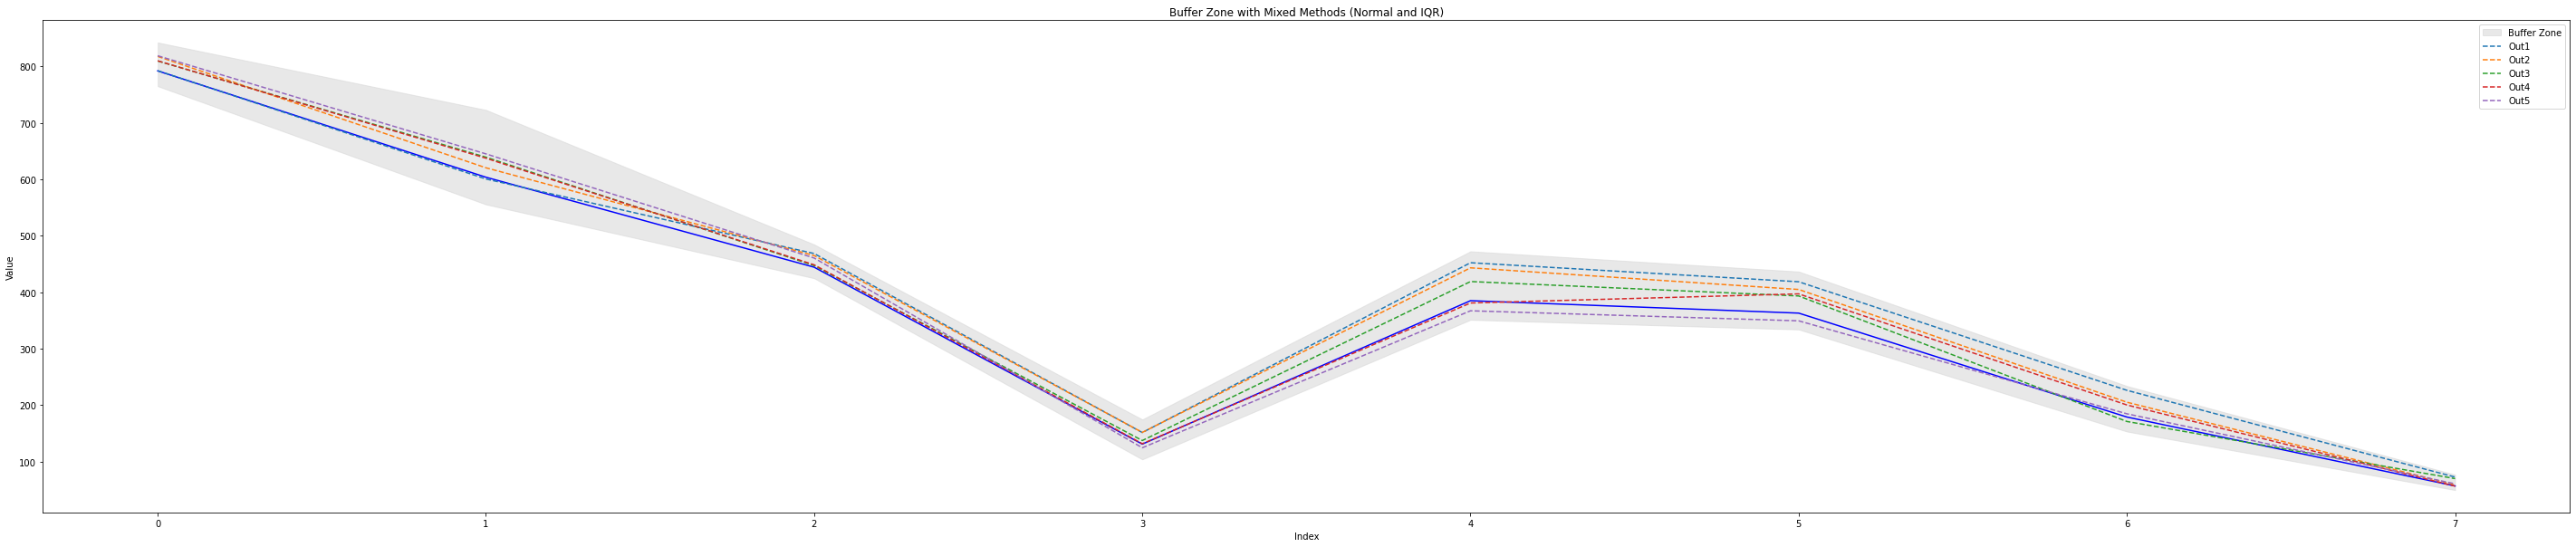

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# 初始化缓冲区上下界的数组
buffer_upper = []
buffer_lower = []

# 获取列的范围
start_col = data.columns.get_loc("Out1")
end_col = data.columns.get_loc("Out1000") + 1

# 对每一行进行正态性检验并计算缓冲区
for i in range(data.shape[0]):
    row_data = data.iloc[i, start_col:end_col]
    
    # Shapiro-Wilk检验
    stat, p_value = shapiro(row_data)
    
    if p_value > 0.05:
        # print("正态")
        # 数据符合正态分布，使用±2个标准差
        mean = row_data.mean()
        std = row_data.std()
        upper = mean + 2 * std
        lower = mean - 2 * std
    else:
        # 数据不符合正态分布，使用IQR
        # print("IQR")
        q1 = row_data.quantile(0.25)
        q3 = row_data.quantile(0.75)
        iqr = q3 - q1
        upper = q3 + 1.5 * iqr
        lower = q1 - 1.5 * iqr
    
    buffer_upper.append(upper)
    buffer_lower.append(lower)

# 将缓冲区上下界转换为数组
buffer_upper = np.array(buffer_upper)
buffer_lower = np.array(buffer_lower)
print(buffer_lower)
print(data["Out0"])
print(buffer_upper)

# 生成x轴
x = np.arange(data.shape[0])

# 绘制缓冲区范围
plt.figure(figsize=(50, 10))
# 绘制Out0数据
plt.plot(x, data["Out0"], color='blue')

plt.fill_between(x, buffer_lower, buffer_upper, color='lightgray', alpha=0.5, label='Buffer Zone')

# 绘制部分数据列以示例
for i in range(5):
    plt.plot(x, data[f"Out{i+1}"], label=f'Out{i+1}', linestyle='--')

plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Buffer Zone with Mixed Methods (Normal and IQR)')
plt.show()

In [18]:
# 计算Out0在缓冲区内的比例
# within_buffer = np.logical_and(out0 >= buffer_lower, out0 <= buffer_upper)
# probability_within_buffer = np.mean(within_buffer)
# 计算比例

def calculate_proportion(values, lower_bound, upper_bound):
    results = {}
    common_count = 0
    total_count = len(values)
    for key, value in values.items():
        if ((value >= lower_bound) & (value <= upper_bound)).any():
            common_count += 1
        
    common_ratio = common_count / total_count
    return common_ratio
probability_within_buffer=calculate_proportion(data["Out0"],buffer_lower,buffer_upper)
probability_within_buffer

1.0

In [17]:

#计算置信区间
from itertools import combinations

def lins_ccc(x, y):
    """计算Lin's Concordance Correlation Coefficient (CCC)"""
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x)
    var_y = np.var(y)
    cov_xy = np.mean((x - mean_x) * (y - mean_y))
    rho = cov_xy / np.sqrt(var_x * var_y)
    ccc = (2 * rho * np.sqrt(var_x) * np.sqrt(var_y)) / (var_x + var_y + (mean_x - mean_y)**2)
    return ccc
    

#//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# 蒙特卡洛抽取10000次并计算R²
def monteCarloMethod(num_samples, train_data):
    monteCarlo_R_values = []
    monteCarlo_CCC_values = []
    sampled_combinations = [np.random.choice(train_data.columns, 2, replace=False) for _ in range(num_samples)]
    for comb in sampled_combinations:
        i, j = comb
        monteCarlo_CCC_values.append(lins_ccc(train_data[i], train_data[j]))
        monteCarlo_R_values.append(r2_score(train_data[i], train_data[j]))

    return monteCarlo_R_values, monteCarlo_CCC_values
    
    
#//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

def getThreshold(reproducedAllError):
    alpha = 0.05
    reproducedAllError = np.sort(reproducedAllError)
    threshold_low = np.percentile(reproducedAllError, alpha/2*100)
    threshold_high = np.percentile(reproducedAllError, (1-alpha/2)*100)
    print(f"R² 95%置信区间: ({threshold_low}, {threshold_high})")
    return threshold_low,threshold_high


# 生成所需列的列名列表
column_names = [f'Out{i}' for i in range(0, 1001)]
data_df = df[column_names]


# 训练集95%置信区间计算
monteCarlo_R_values, monteCarlo_CCC_values = monteCarloMethod(10000, data_df)
R_ci_low,R_ci_high = getThreshold(monteCarlo_R_values)
CCC_ci_low,CCC_ci_high = getThreshold(monteCarlo_CCC_values)

print(f"所有的R² 95%置信区间: ({R_ci_low}, {R_ci_high})")
print(f"所有的Lin's CCC 95%置信区间: ({CCC_ci_low}, {CCC_ci_high})")

# 随机划分训练集和验证集
train_indices = np.random.choice(data_df.columns[1:], size=int(0.8*1000), replace=False)
# print(train_indices)
train_data = data_df[train_indices]
# print(train_data)
# 验证集
validation_indices = list(set(data_df.columns[1:]) - set(train_indices))
validation_data = data_df[validation_indices]

# 训练集95%置信区间计算
monteCarlo_R_values, monteCarlo_CCC_values = monteCarloMethod(10000, train_data)
R_ci_low,R_ci_high = getThreshold(monteCarlo_R_values)
CCC_ci_low,CCC_ci_high = getThreshold(monteCarlo_CCC_values)

print(f"训练集R² 95%置信区间: ({R_ci_low}, {R_ci_high})")
print(f"训练集Lin's CCC 95%置信区间: ({CCC_ci_low}, {CCC_ci_high})")


# 计算验证集的统计检验量，对训练集中，计算每2对之间的R2和Lin's CCC
validation_combinations = combinations(validation_data.columns, 2)
validation_R_values = []
validation_CCC_values = []
for comb in validation_combinations:
    i, j = comb
    validation_R_values.append(r2_score(validation_data[i], validation_data[j]))
    validation_CCC_values.append(lins_ccc(validation_data[i], validation_data[j]))

# 验证集检验量是否在置信区间内的比例
R_ratio = calculate_proportion(R_ci_low,R_ci_high, validation_R_values)
CCC_ratio = calculate_proportion(CCC_ci_low,CCC_ci_high, validation_CCC_values)

print(f"验证集R²在95%置信区间内的比例: {R_ratio:.2f}")
print(f"验证集Lin's CCC在95%置信区间内的比例: {CCC_ratio:.2f}")


#//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////



# 计算原始数据与复现数据之间的统计检验量
real_R_values = [r2_score(data_df['Out0'], data_df[f'Out{i}']) for i in range(1, 1001)]
real_CCC_values = [lins_ccc(data_df['Out0'], data_df[f'Out{i}']) for i in range(1, 1001)]

test=calculate_proportion(R_ci_low,R_ci_high, real_R_values)
print(f"T在原始数据R²置信区间内的概率: {test:.2f}")

test2=calculate_proportion(CCC_ci_low,CCC_ci_high, real_CCC_values)
print(f"T在原始数据Lin's CCC置信区间内的概率: {test2:.2f}")




R² 95%置信区间: (0.964927930601092, 0.9979892123240326)
R² 95%置信区间: (0.9826327965489371, 0.9989801428263703)
所有的R² 95%置信区间: (0.964927930601092, 0.9979892123240326)
所有的Lin's CCC 95%置信区间: (0.9826327965489371, 0.9989801428263703)
R² 95%置信区间: (0.9634368478004371, 0.9980629355944095)
R² 95%置信区间: (0.9820217617738299, 0.9990351326218946)
训练集R² 95%置信区间: (0.9634368478004371, 0.9980629355944095)
训练集Lin's CCC 95%置信区间: (0.9820217617738299, 0.9990351326218946)


TypeError: object of type 'numpy.float64' has no len()

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from itertools import combinations

# 计算基本统计量
def calculate_statistics(data):
    mean_val = np.mean(data)
    variance_val = np.var(data)
    std_dev_val = np.std(data)
    return mean_val, variance_val, std_dev_val

# Bootstrap抽样并计算统计检验量
def bootstrap_sampling(num_samples, data_df):
    bootstrap_means = []
    bootstrap_variances = []
    bootstrap_std_devs = []
    validation_means = []
    validation_variances = []
    validation_std_devs = []
    n = data_df.shape[0]  # Number of rows
    for _ in range(num_samples):
        sample_indices = np.random.choice(data_df.columns[1:], size=n, replace=True)
        sampled_data = data_df[sample_indices]
        mean_val, variance_val, std_dev_val = calculate_statistics(sampled_data.values.flatten())
        bootstrap_means.append(mean_val)
        bootstrap_variances.append(variance_val)
        bootstrap_std_devs.append(std_dev_val)
        
        # 计算验证集（未被抽取到的数据）的统计量
        validation_indices = list(set(data_df.columns[1:]) - set(sample_indices))
        if validation_indices:
            validation_data = data_df[validation_indices]
            mean_val, variance_val, std_dev_val = calculate_statistics(validation_data.values.flatten())
            validation_means.append(mean_val)
            validation_variances.append(variance_val)
            validation_std_devs.append(std_dev_val)
    
    return bootstrap_means, bootstrap_variances, bootstrap_std_devs, validation_means, validation_variances, validation_std_devs

# 计算置信区间
def calculate_confidence_interval(values, alpha=0.05):
    values = np.sort(values)
    lower_bound = np.percentile(values, alpha/2*100)
    upper_bound = np.percentile(values, (1-alpha/2)*100)
    return lower_bound, upper_bound


# 计算Lin's CCC
def lins_ccc(x, y):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x)
    var_y = np.var(y)
    cov_xy = np.mean((x - mean_x) * (y - mean_y))
    rho = cov_xy / np.sqrt(var_x * var_y)
    ccc = (2 * rho * np.sqrt(var_x) * np.sqrt(var_y)) / (var_x + var_y + (mean_x - mean_y)**2)
    return ccc

# 蒙特卡洛抽样并计算R²和Lin's CCC
def monteCarloMethod(num_samples, train_data):
    monteCarlo_R_values = []
    monteCarlo_CCC_values = []
    sampled_combinations = [np.random.choice(train_data.columns, 2, replace=False) for _ in range(num_samples)]
    for comb in sampled_combinations:
        i, j = comb
        monteCarlo_CCC_values.append(lins_ccc(train_data[i], train_data[j]))
        monteCarlo_R_values.append(r2_score(train_data[i], train_data[j]))
    return monteCarlo_R_values, monteCarlo_CCC_values


# 方案一：基于Bootstrap自采样的统计检验----------------------------------------------------------------------------------------------------------------------------------------
num_samples = 2000
bootstrap_means, bootstrap_variances, bootstrap_std_devs, validation_means, validation_variances, validation_std_devs = bootstrap_sampling(num_samples, data_df)

# 计算95%置信区间
mean_ci_low, mean_ci_high = calculate_confidence_interval(bootstrap_means)
variance_ci_low, variance_ci_high = calculate_confidence_interval(bootstrap_variances)
std_dev_ci_low, std_dev_ci_high = calculate_confidence_interval(bootstrap_std_devs)

print(f"训练集均值 95%置信区间: ({mean_ci_low}, {mean_ci_high})")
print(f"训练集方差 95%置信区间: ({variance_ci_low}, {variance_ci_high})")
print(f"训练集标准差 95%置信区间: ({std_dev_ci_low}, {std_dev_ci_high})")

# 计算验证集的统计检验量是否在置信区间内的比例
mean_proportion = calculate_proportion(validation_means, mean_ci_low, mean_ci_high)
variance_proportion = calculate_proportion(validation_variances, variance_ci_low, variance_ci_high)
std_dev_proportion = calculate_proportion(validation_std_devs, std_dev_ci_low, std_dev_ci_high)

print(f"验证集均值在95%置信区间内的比例: {mean_proportion:.2f}")
print(f"验证集方差在95%置信区间内的比例: {variance_proportion:.2f}")
print(f"验证集标准差在95%置信区间内的比例: {std_dev_proportion:.2f}")

# 计算原始结果数据的统计检验量
real_mean_val, real_variance_val, real_std_dev_val = calculate_statistics(data_df['Out0'].values)
print(f"1111: {real_mean_val},{real_variance_val},{real_std_dev_val}")

# 计算原始结果数据统计检验量是否在训练集置信区间内的比例
# mean_in_ci = calculate_proportion(real_mean_val, mean_ci_low, mean_ci_high)
# variance_in_ci = calculate_proportion(real_variance_val, variance_ci_low, variance_ci_high)
# std_dev_in_ci = calculate_proportion(real_std_dev_val, std_dev_ci_low, std_dev_ci_high)
# 计算原始结果数据统计检验量是否在训练集置信区间内的比例
mean_in_ci = (mean_ci_low <= real_mean_val <= mean_ci_high)
variance_in_ci = (variance_ci_low <= real_variance_val <= variance_ci_high)
std_dev_in_ci = (std_dev_ci_low <= real_std_dev_val <= std_dev_ci_high)


print(f"原始数据均值在训练集置信区间内: {mean_in_ci}")
print(f"原始数据方差在训练集置信区间内: {variance_in_ci}")
print(f"原始数据标准差在训练集置信区间内: {std_dev_in_ci}")

# 方案二：基于蒙特卡洛检验来衡量实验的随机误差--------------------------------------------------------------------
train_indices = np.random.choice(data_df.columns[1:], size=int(0.8*1000), replace=False)
train_data = data_df[train_indices]
validation_indices = list(set(data_df.columns[1:]) - set(train_indices))
validation_data = data_df[validation_indices]

# 训练集95%置信区间计算
monteCarlo_R_values, monteCarlo_CCC_values = monteCarloMethod(10000, train_data)
R_ci_low, R_ci_high = calculate_confidence_interval(monteCarlo_R_values)
CCC_ci_low, CCC_ci_high = calculate_confidence_interval(monteCarlo_CCC_values)

print(f"训练集R² 95%置信区间: ({R_ci_low}, {R_ci_high})")
print(f"训练集Lin's CCC 95%置信区间: ({CCC_ci_low}, {CCC_ci_high})")

# 计算验证集的统计检验量，对训练集中，计算每2对之间的R2和Lin's CCC
validation_combinations = combinations(validation_data.columns, 2)
validation_R_values = []
validation_CCC_values = []
for comb in validation_combinations:
    i, j = comb
    validation_R_values.append(r2_score(validation_data[i], validation_data[j]))
    validation_CCC_values.append(lins_ccc(validation_data[i], validation_data[j]))

# 验证集检验量是否在置信区间内的比例
R_ratio = calculate_proportion(validation_R_values, R_ci_low, R_ci_high)
CCC_ratio = calculate_proportion(validation_CCC_values, CCC_ci_low, CCC_ci_high)

print(f"验证集R²在95%置信区间内的比例: {R_ratio:.2f}")
print(f"验证集Lin's CCC在95%置信区间内的比例: {CCC_ratio:.2f}")

# 计算原始数据与复现数据之间的统计检验量
real_R_values = [r2_score(data_df['Out0'], data_df[f'Out{i}']) for i in range(1, 1001)]
real_CCC_values = [lins_ccc(data_df['Out0'], data_df[f'Out{i}']) for i in range(1, 1001)]

R_ratio_original = calculate_proportion(real_R_values, R_ci_low, R_ci_high)
CCC_ratio_original = calculate_proportion(real_CCC_values, CCC_ci_low, CCC_ci_high)

print(f"T在原始数据R²置信区间内的概率: {R_ratio_original:.2f}")
print(f"T在原始数据Lin's CCC置信区间内的概率: {CCC_ratio_original:.2f}")


训练集均值 95%置信区间: (381.26823318398436, 393.07814024726565)
训练集方差 95%置信区间: (53450.08079499111, 58893.68274636408)
训练集标准差 95%置信区间: (231.19273514047708, 242.6802067015346)
验证集均值在95%置信区间内的比例: 1.00
验证集方差在95%置信区间内的比例: 1.00
验证集标准差在95%置信区间内的比例: 1.00
1111: 369.299655625,53800.5122566878,231.94937433993607
原始数据均值在训练集置信区间内: False
原始数据方差在训练集置信区间内: True
原始数据标准差在训练集置信区间内: True
训练集R² 95%置信区间: (0.9644761070017205, 0.998058153997049)
训练集Lin's CCC 95%置信区间: (0.9824093515783224, 0.9990268794150822)
验证集R²在95%置信区间内的比例: 0.96
验证集Lin's CCC在95%置信区间内的比例: 0.95
T在原始数据R²置信区间内的概率: 0.93
T在原始数据Lin's CCC置信区间内的概率: 0.94
